In [1]:
from flax import linen as nn, struct
from flax.training.train_state import TrainState
from functools import cache, partial
from jax.flatten_util import ravel_pytree
from optax import (
    softmax_cross_entropy_with_integer_labels as xent
)
from sklearn.datasets import load_digits
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# jax.config.update("jax_enable_x64", True)
os.environ["CUDA_VISIBLE_DEVICES"] = "2,3,4,5,6,7"


class MLP(nn.Module):
    hidden_sizes: tuple[int, ...]
    out_features: int

    @nn.compact
    def __call__(self, x):
        for feat in self.hidden_sizes:
            scale = feat ** -0.5
            bias_init = nn.initializers.normal(stddev=scale)

            x = nn.Dense(feat, bias_init=bias_init)(x)
            x = nn.gelu(x)

        x = nn.Dense(self.out_features, bias_init=bias_init)(x)
        return x


@struct.dataclass
class TrainConfig:
    batch_size: int = 64
    num_epochs: int = 25

    opt: str = "sgd"


@cache
def random_rotation(d: int):
    key = jax.random.PRNGKey(0)
    return jax.random.orthogonal(key, d)


def make_apply_full(model, unraveler):
    """Make an apply function that takes the full parameter vector."""
    def apply_full(raveled, x):
        params = unraveler(raveled)
        return model.apply(params, x)
    
    return apply_full


def make_apply_subspace(model, unraveler, params0, basis):
    """Make an apply function that takes a small parameter vector."""
    def apply_subspace(small_params, x):
        raveled = params0 + basis.T @ small_params
        return model.apply(unraveler(raveled), x)
    
    return apply_subspace

# Loss function
def compute_loss(params, apply_fn, X, Y):
    logits = apply_fn(params['p'], X)
    preds = jnp.argmax(logits, axis=-1)

    loss = xent(logits, Y).mean()
    acc = jnp.mean(preds == Y)
    return loss, acc


def train(params, x_train, y_train, x_test, y_test, apply_fn, cfg: TrainConfig):
    # Create the batches
    X_batched = jnp.reshape(x_train, (-1, cfg.batch_size, 64))
    Y_batched = jnp.reshape(y_train, (-1, cfg.batch_size))

    # LR schedule
    num_steps = cfg.num_epochs * len(x_train) // cfg.batch_size

    # Define the optimizer and training state
    if cfg.opt == "adam":
        sched = optax.cosine_decay_schedule(3e-3, num_steps)
        tx = optax.adam(learning_rate=sched, eps_root=1e-8)
    else:
        sched = optax.cosine_decay_schedule(0.1, num_steps)
        tx = optax.chain(
            # optax.add_decayed_weights(0.01),
            optax.sgd(learning_rate=sched, momentum=0.9)
        )

    state = TrainState.create(apply_fn=apply_fn, params=dict(p=params), tx=tx)

    # Forward and backward pass
    loss_and_grad = jax.value_and_grad(compute_loss, has_aux=True)

    def train_step(state: TrainState, batch):
        loss, grads = loss_and_grad(state.params, state.apply_fn, *batch)
        return state.apply_gradients(grads=grads), loss

    def epoch_step(state: TrainState, epoch) -> tuple[TrainState, tuple[jnp.ndarray, jnp.ndarray]]:
        state, (losses, accs) = jax.lax.scan(train_step, state, (X_batched, Y_batched))
        return state, (losses.mean(), accs.mean())

    state, (train_loss, _) = jax.lax.scan(epoch_step, state, jnp.arange(cfg.num_epochs))
    raveled, _ = ravel_pytree(state.params)

    # Test loss
    logits = state.apply_fn(state.params['p'], x_test)
    test_loss = xent(logits, y_test).mean()
    return raveled, test_loss#, train_loss # test_loss, train_loss[-1]



In [2]:

from sklearn.model_selection import train_test_split

In [4]:
261+512 - 597

176

In [111]:
X, Y = load_digits(return_X_y=True)
X = X / 16.0  # Normalize

train_size = 1024
test_size = 261 + 1536 - train_size
# Split data into "train" and "test" sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=test_size, random_state=0, stratify=Y,
)


In [6]:
X_random = jax.random.uniform(jax.random.PRNGKey(23), X_test.shape)

2024-10-02 21:21:32.130595: W external/xla/xla/service/gpu/nvptx_compiler.cc:893] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version 12.6.68. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [112]:
seed = 0
key = jax.random.PRNGKey(seed)

d_inner = 64
model = MLP(hidden_sizes=(d_inner,), out_features=10)



params_init = model.init(key, X_train)
params_raveled, unravel = ravel_pytree(params_init)

cfg = TrainConfig()

In [113]:
def train_fn(params_raveled):
    params = unravel(params_raveled)
    final_params, test_loss = train(params, X_train, Y_train, X_test, Y_test, model.apply, cfg)
    return ravel_pytree(final_params)[0]

In [114]:
final_params, test_loss = train(params_init, X_train, Y_train, X_test, Y_test, model.apply, cfg)

In [116]:
final_params_raveled, _ = ravel_pytree(final_params)

In [11]:
J = jax.jacfwd(train_fn)(params_raveled)
u_train, s_train, vh_train = jnp.linalg.svd(J)

In [12]:
def train_logits(params_raveled, x):
    params = unravel(params_raveled)
    return model.apply(params, x)

def train_probs(params_raveled, x):
    return jax.nn.softmax(train_logits(params_raveled, x), axis=-1)

def train_logprobs(params_raveled, x):
    return jax.nn.log_softmax(train_logits(params_raveled, x), axis=-1)


In [13]:
jac_train_logits = jax.jacfwd(train_logits)
jac_train_probs = jax.jacfwd(train_probs)
jac_train_logprobs = jax.jacfwd(train_logprobs)

In [14]:

J_logits = jac_train_logits(final_params_raveled, X_test)
J_logits = jnp.reshape(J_logits, (-1, 4810))
u_final, s_final, vh_final = jnp.linalg.svd(J_logits)

In [14]:

J_logits = jac_train_logits(params_raveled, X_test)
J_logits = jnp.reshape(J_logits, (-1, 4810))
u_init, s_init, vh_init = jnp.linalg.svd(J_logits)

In [15]:

J_logits = jac_train_logits(params_raveled, X_random)
J_logits = jnp.reshape(J_logits, (-1, 4810))
u_random, s_random, vh_random = jnp.linalg.svd(J_logits)

In [66]:
J = jac_train_logprobs(params_raveled, X_random)
J = jnp.reshape(J, (-1, 4810))
u_random_lp, s_random_lp, vh_random_lp = jnp.linalg.svd(J)

In [115]:
J = jac_train_logprobs(params_raveled, X_test)
J = jnp.reshape(J, (-1, 4810))
u_init_lp, s_init_lp, vh_init_lp = jnp.linalg.svd(J)


In [ ]:

J = jac_train_logprobs(final_params_raveled, X_test)
J = jnp.reshape(J, (-1, 4810))
u_final_lp, s_final_lp, vh_final_lp = jnp.linalg.svd(J)

In [17]:
J = jac_train_probs(params_raveled, X_test)
J = jnp.reshape(J, (-1, 4810))
u_init_p, s_init_p, vh_init_p = jnp.linalg.svd(J)

In [18]:
J = jac_train_probs(final_params_raveled, X_test)
J = jnp.reshape(J, (-1, 4810))
u_final_p, s_final_p, vh_final_p = jnp.linalg.svd(J)

In [19]:
random_baseline = jax.random.normal(key, vh_init.shape)
random_baseline = jnp.linalg.qr(random_baseline)[0]

In [20]:
def principal_cosines(x0, x1):
    '''
    Compute the principal angle cosines between two subspaces x0 and x1.

    x0, x1: jnp.ndarray
        x0[i] and x1[i] are orthonormal bases for the subspaces.
        shape: (n, d)
        d is the dimension of the parent space.
        n0 and n1 do not have to be the same.
    '''
    _, s, _ = jnp.linalg.svd(x0 @ x1.T)
    return jnp.clip(s, -1, 1)

def geodesic_dist(x0, x1):
    '''
    Compute the geodesic distance between two subspaces x0 and x1.
    '''
    cosines = principal_cosines(x0, x1)
    return jnp.sqrt(jnp.sum(jnp.arccos(cosines)**2))

In [85]:
def plot_setup(figsize=(5, 3)):
    # Define general parameters for plot suitable for LaTeX paper
    plt.figure(figsize=figsize)  # Adjust figure size to be more paper-friendly
    plt.rc('font', size=10)         # Default text size
    plt.rc('axes', titlesize=12)    # Title font size
    plt.rc('axes', labelsize=10)    # X and Y label size
    plt.rc('xtick', labelsize=8)    # X tick label size
    plt.rc('ytick', labelsize=8)    # Y tick label size
    plt.rc('legend', fontsize=10)   # Legend font size
    plt.rc('lines', linewidth=1.5)  # Line width for better visibility in print

# Nullspace investigation

In [67]:
vh_random_lp.shape

(4810, 4810)

In [76]:
def flatten_dict(d):
    new_d = {}
    for k, v in d.items():
        if isinstance(v, dict):
            for k2, v2 in flatten_dict(v).items():
                new_d[(k,) + k2] = v2
        else:
            new_d[(k,)] = v

    return new_d

In [77]:
example_dict = {"a": {"b": 1, "c": 2, "d": {"e": 3}}, "f": 4}
flatten_dict(example_dict)

{('a', 'b'): 1, ('a', 'c'): 2, ('a', 'd', 'e'): 3, ('f',): 4}

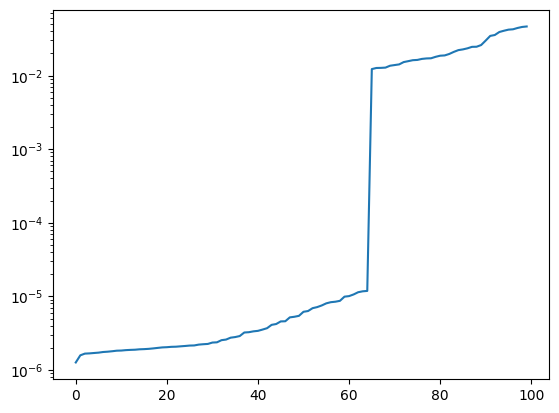

In [81]:
plt.plot(jnp.flip(s_random_lp)[:100])
plt.yscale("log")

In [92]:
import numpy as np

In [132]:
n = 4810

diffs_random = np.zeros((n, 4))

for i in range(n):
    param_diffs = unravel(vh_random_lp[-(i + 1)])
    flat_diffs = flatten_dict(param_diffs)
    for j, key in enumerate(flat_diffs):
        block = flat_diffs[key]
        diffs_random[i, j] = jnp.linalg.norm(block) / jnp.sqrt(jnp.prod(jnp.array(block.shape)))


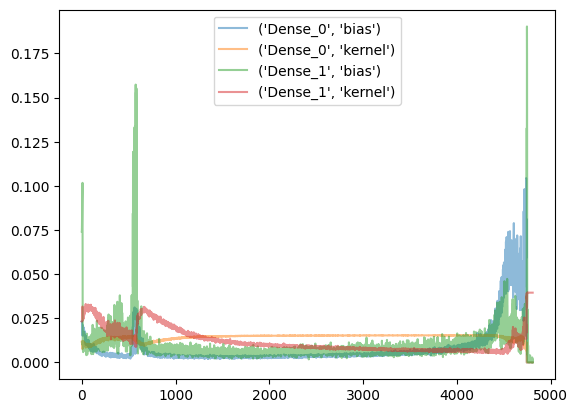

In [151]:
keys = list(flatten_dict(unravel(params_raveled)).keys())
for i in range(4):
    plt.plot(jnp.flip(diffs_random[:, i]), alpha=0.5, label=f"{keys[i][1:]}")
plt.legend()
#plt.yscale("log")
plt.show()

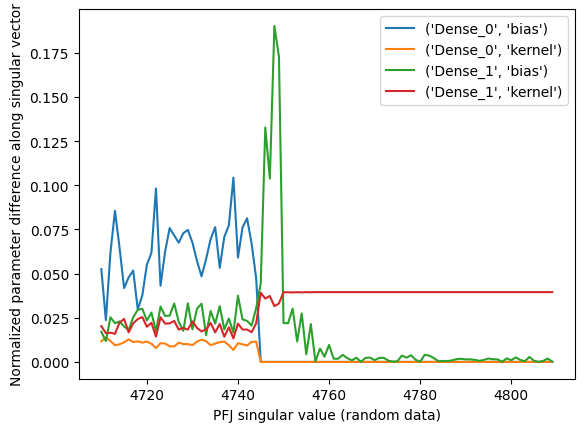

In [150]:
keys = list(flatten_dict(unravel(params_raveled)).keys())
for i in range(4):
    idx = jnp.arange(4810-100, 4810-0)
    plt.plot(idx, jnp.flip(diffs_random[:, i])[idx], label=f"{keys[i][1:]}")
plt.legend()
plt.xlabel("PFJ singular value (random data)")
plt.ylabel("Normalized parameter difference along singular vector")
plt.show()

In [120]:
n = 4810

diffs = np.zeros((n, 4))

for i in range(n):
    param_diffs = unravel(vh_init_lp[-(i + 1)])
    flat_diffs = flatten_dict(param_diffs)
    for j, key in enumerate(flat_diffs):
        block = flat_diffs[key]
        diffs[i, j] = jnp.linalg.norm(block) / jnp.sqrt(jnp.prod(jnp.array(block.shape)))


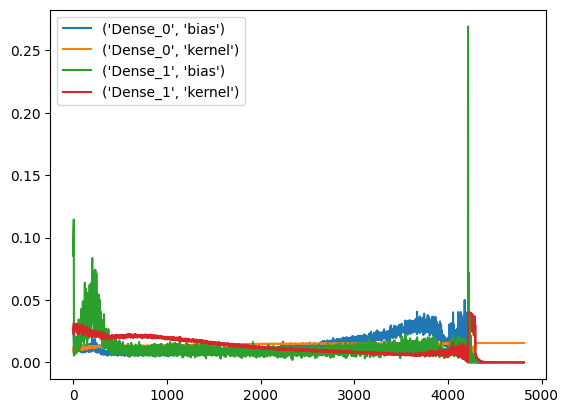

In [121]:
keys = list(flatten_dict(unravel(params_raveled)).keys())
for i in range(4):
    plt.plot(jnp.flip(diffs[:, i]), label=f"{keys[i][1:]}")
plt.legend()
plt.show()

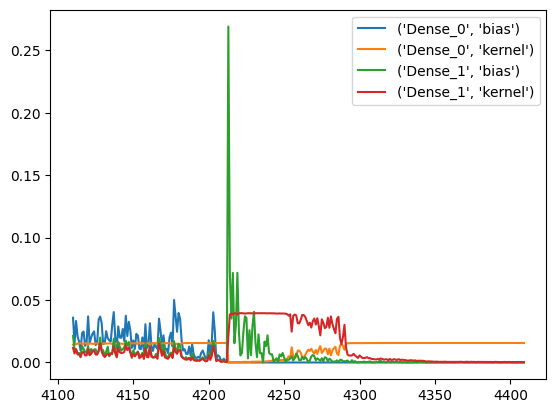

In [131]:
keys = list(flatten_dict(unravel(params_raveled)).keys())
for i in range(4):
    idx = jnp.arange(4810-700, 4810-400)
    plt.plot(idx, jnp.flip(diffs[:, i])[idx], label=f"{keys[i][1:]}")
plt.legend()
plt.show()

In [135]:
n = 4810

diffs = np.zeros((n, 4))

for i in range(n):
    param_diffs = unravel(vh_train[-(i + 1)])
    flat_diffs = flatten_dict(param_diffs)
    for j, key in enumerate(flat_diffs):
        block = flat_diffs[key]
        diffs[i, j] = jnp.linalg.norm(block) / jnp.sqrt(jnp.prod(jnp.array(block.shape)))


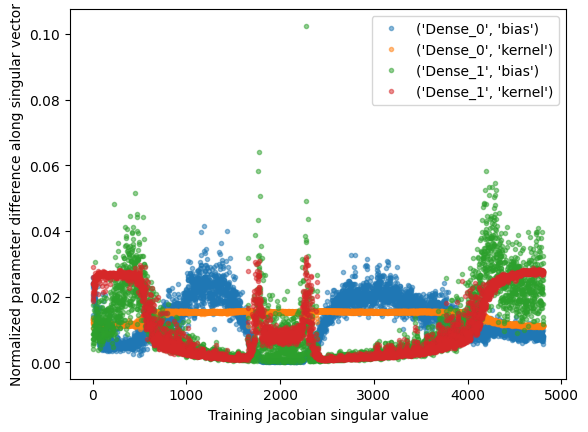

In [148]:
keys = list(flatten_dict(unravel(params_raveled)).keys())
for i in range(4):
    plt.plot(jnp.flip(diffs[:, i]), '.', alpha=0.5, label=f"{keys[i][1:]}")
plt.legend()
#plt.yscale("log")
plt.xlabel("Training Jacobian singular value")
plt.ylabel("Normalized parameter difference along singular vector")
plt.show()

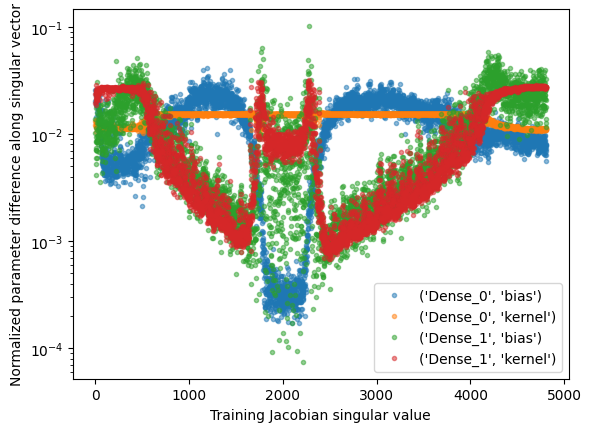

In [ ]:
keys = list(flatten_dict(unravel(params_raveled)).keys())
for i in range(4):
    plt.plot(jnp.flip(diffs[:, i]), '.', alpha=0.5, label=f"{keys[i][1:]}")
plt.legend()
plt.yscale("log")
plt.xlabel("Training Jacobian singular value")
plt.ylabel("Normalized parameter difference along singular vector")
plt.show()

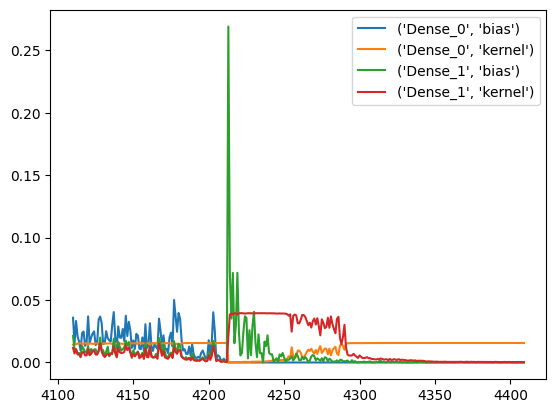

In [ ]:
keys = list(flatten_dict(unravel(params_raveled)).keys())
for i in range(4):
    idx = jnp.arange(4810-700, 4810-400)
    plt.plot(idx, jnp.flip(diffs[:, i])[idx], label=f"{keys[i][1:]}")
plt.legend()
plt.show()

In [88]:
for k, v in flatten_dict(unravel(params_raveled)).items():
    print(k, v.shape, (jnp.prod(jnp.array(v.shape))))

('params', 'Dense_0', 'bias') (64,) 64
('params', 'Dense_0', 'kernel') (64, 64) 4096
('params', 'Dense_1', 'bias') (10,) 10
('params', 'Dense_1', 'kernel') (64, 10) 640


In [ ]:
train_sizes = jnp.arange(128, 1536, 128)

ks = {"test": [], "random": []}
topgaps = {"test": [], "random": []}

for train_size in tqdm(train_sizes):
    # Split data into "train" and "test" sets
    test_size = 261 + 1536 - int(train_size)
    _, my_X_test, _, my_Y_test = train_test_split(
        X, Y, test_size=test_size, random_state=0, stratify=Y,
    )
    my_X_random = jax.random.uniform(jax.random.key(train_size), my_X_test.shape)

    for setting, my_X in [("test", my_X_test), ("random", my_X_random)]:

        J = jac_train_logprobs(params_raveled, my_X)
        J = jnp.reshape(J, (-1, 4810))
        u_init_lp, s_init_lp, vh_init_lp = jnp.linalg.svd(J)

        gaps = -jnp.diff(jnp.log10(s_init_lp))
        top = jnp.argmax(gaps)

        print(train_size)
        k = 4810 - top - 1
        print(k, gaps[top], s_init_lp[top:top+2])
        print(test_size - k, test_size + k)
        print()

        ks[setting].append(k)
        topgaps[setting].append(gaps[top])

  0%|          | 0/11 [00:00<?, ?it/s]

128
1 0.77683353 [3.9361966e-10 6.5802683e-11]
1668 1670



  9%|▉         | 1/11 [00:38<06:20, 38.07s/it]

128
65 2.9323921 [1.2581980e-02 1.4701337e-05]
1604 1734

256
516 1.0500438 [1.3106699e-04 1.1680181e-05]
1025 2057



 18%|█▊        | 2/11 [01:15<05:41, 37.89s/it]

256
65 2.883904 [1.0385770e-02 1.3568585e-05]
1476 1606

384
534 1.0580397 [1.2912648e-04 1.1297323e-05]
879 1947



 27%|██▋       | 3/11 [01:53<05:01, 37.71s/it]

384
65 2.9077694 [1.05913477e-02 1.30972885e-05]
1348 1478

512
543 1.0556779 [1.2575636e-04 1.1062470e-05]
742 1828



 36%|███▋      | 4/11 [02:29<04:19, 37.04s/it]

512
65 2.9446406 [1.0401592e-02 1.1815680e-05]
1220 1350

640
552 1.1165371 [1.2131981e-04 9.2767268e-06]
605 1709



 45%|████▌     | 5/11 [03:05<03:40, 36.80s/it]

640
65 2.8733666 [8.185489e-03 1.095665e-05]
1092 1222

768
561 1.1063585 [1.16362484e-04 9.10865765e-06]
468 1590



 55%|█████▍    | 6/11 [03:40<03:00, 36.18s/it]

768
65 2.8543568 [7.4631120e-03 1.0436702e-05]
964 1094

896
570 1.2843277 [1.1012672e-04 5.7222269e-06]
331 1471



 64%|██████▎   | 7/11 [04:15<02:23, 35.88s/it]

896
65 3.0666056 [8.5175531e-03 7.3064925e-06]
836 966

1024
597 1.677427 [3.3270445e-04 6.9924795e-06]
176 1370



 73%|███████▎  | 8/11 [04:49<01:45, 35.17s/it]

1024
65 2.8766031 [5.7045338e-03 7.5790886e-06]
708 838

1152
1 1.1656437 [6.185146e-11 4.223826e-12]
644 646



 82%|████████▏ | 9/11 [05:22<01:08, 34.47s/it]

1152
65 2.3063822 [2.9575520e-03 1.4606623e-05]
580 710

1280
634 0.6228075 [3.212329e-05 7.656185e-06]
-117 1151



 91%|█████████ | 10/11 [05:52<00:33, 33.16s/it]

1280
157 2.2361436 [1.729825e-03 1.004289e-05]
360 674

1408
1309 2.7835908 [3.7724271e-03 6.2091217e-06]
-920 1698



100%|██████████| 11/11 [06:10<00:00, 33.64s/it]

1408
1309 3.5769258 [3.9282251e-02 1.0405676e-05]
-920 1698



In [ ]:
ks

{'test': [Array(1, dtype=int32),
  Array(516, dtype=int32),
  Array(534, dtype=int32),
  Array(543, dtype=int32),
  Array(552, dtype=int32),
  Array(561, dtype=int32),
  Array(570, dtype=int32),
  Array(597, dtype=int32),
  Array(1, dtype=int32),
  Array(634, dtype=int32),
  Array(1309, dtype=int32)],
 'random': [Array(65, dtype=int32),
  Array(65, dtype=int32),
  Array(65, dtype=int32),
  Array(65, dtype=int32),
  Array(65, dtype=int32),
  Array(65, dtype=int32),
  Array(65, dtype=int32),
  Array(65, dtype=int32),
  Array(65, dtype=int32),
  Array(157, dtype=int32),
  Array(1309, dtype=int32)]}

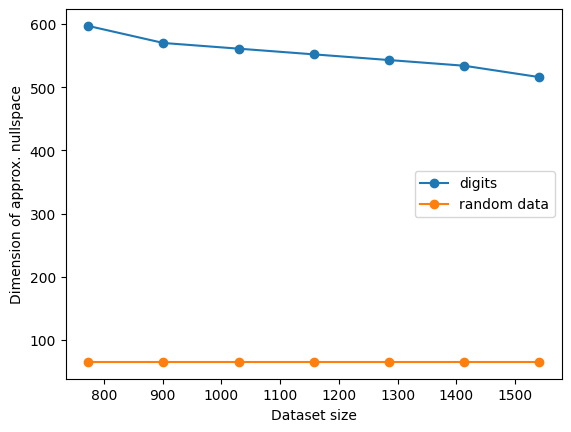

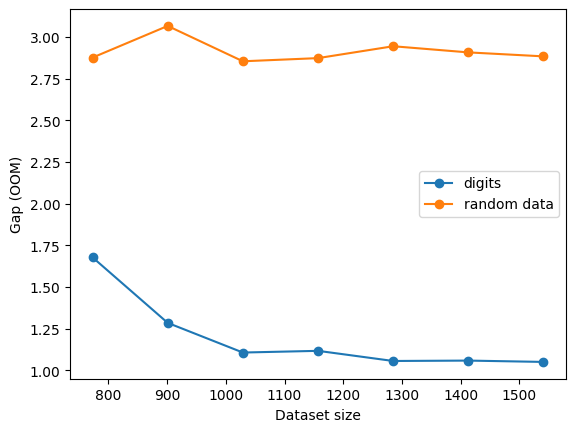

In [ ]:
plt.plot(261 + 1536 - train_sizes[1:-3], ks["test"][1:-3], 'o-', label="digits")
plt.plot(261 + 1536 - train_sizes[1:-3], ks["random"][1:-3], 'o-', label="random data")
plt.xlabel("Dataset size")
plt.ylabel("Dimension of approx. nullspace")
plt.legend()
plt.show()
plt.plot(261 + 1536 - train_sizes[1:-3], topgaps["test"][1:-3], 'o-', label="digits")
plt.plot(261 + 1536 - train_sizes[1:-3], topgaps["random"][1:-3], 'o-', label="random data")
plt.xlabel("Dataset size")
plt.ylabel("Gap (OOM)")
plt.legend()
plt.show()

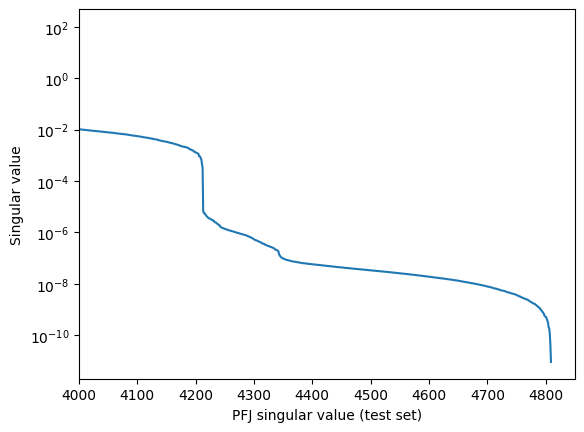

In [152]:
plt.plot(s_init_lp, label="init (logprobs)")
plt.xlim(4000, 4850)
plt.yscale("log")
plt.xlabel("PFJ singular value (test set)")
plt.ylabel("Singular value")
plt.show()

In [ ]:
s_init_lp[-600:]

Array([4.11294587e-03, 3.99102457e-03, 3.93383484e-03, 3.86430835e-03,
       3.85673041e-03, 3.82410921e-03, 3.77207249e-03, 3.74161266e-03,
       3.71548068e-03, 3.68687813e-03, 3.65853659e-03, 3.60206282e-03,
       3.58570972e-03, 3.55245639e-03, 3.42592690e-03, 3.39260302e-03,
       3.36895208e-03, 3.32945609e-03, 3.24890902e-03, 3.22995475e-03,
       3.21247708e-03, 3.15203820e-03, 3.09255719e-03, 3.03372927e-03,
       2.98380060e-03, 2.94124591e-03, 2.91244569e-03, 2.79818405e-03,
       2.77659507e-03, 2.66358629e-03, 2.55042547e-03, 2.52641854e-03,
       2.40361970e-03, 2.28238991e-03, 2.13584420e-03, 2.11020070e-03,
       2.04423326e-03, 1.95688801e-03, 1.84079981e-03, 1.80430547e-03,
       1.70615339e-03, 1.54960912e-03, 1.46610697e-03, 1.29966752e-03,
       1.16113271e-03, 1.04975386e-03, 1.00870838e-03, 8.76398699e-04,
       7.74647167e-04, 5.93636534e-04, 5.89255826e-04, 4.91811312e-04,
       4.19800053e-04, 3.91937792e-04, 3.02875298e-04, 2.62493471e-04,
      

# Experiments

In [32]:
orths = []

for seed in range(10):
    key = jax.random.PRNGKey(seed)
    orths.append(jax.random.orthogonal(key, 4810))

In [33]:
dims = [0, 1000, 2000, 3000]
dists = {}
for dim in dims:
    dists[dim] = []
    for orth in orths:
        dists[dim].append(geodesic_dist(orth[:dim], orths[0][:dim]))

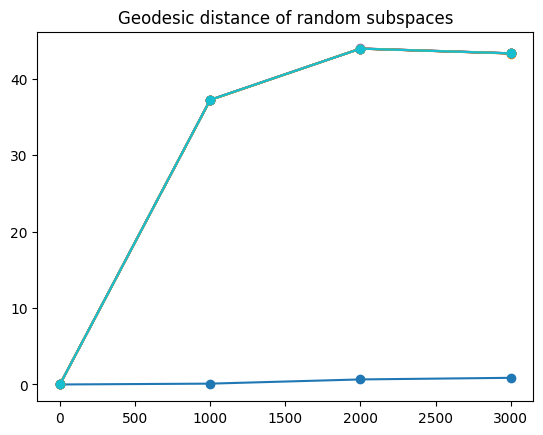

In [37]:

for i, orth in enumerate(orths):
    plt.plot(dims, [dists[dim][i] for dim in dims], 'o-')
plt.title("Geodesic distance of random subspaces")
plt.show()

In [22]:
bulkfirst = jnp.argsort(jnp.abs(jnp.log(s_train)))

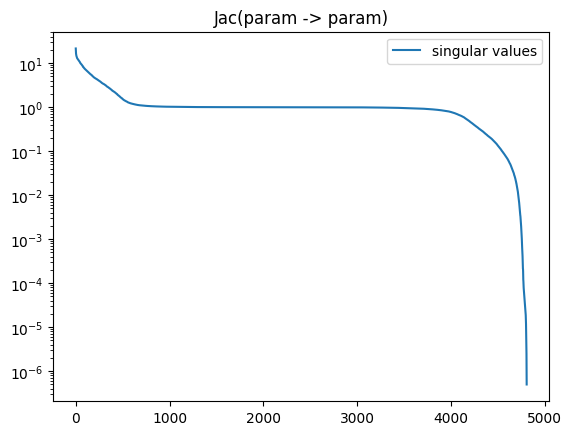

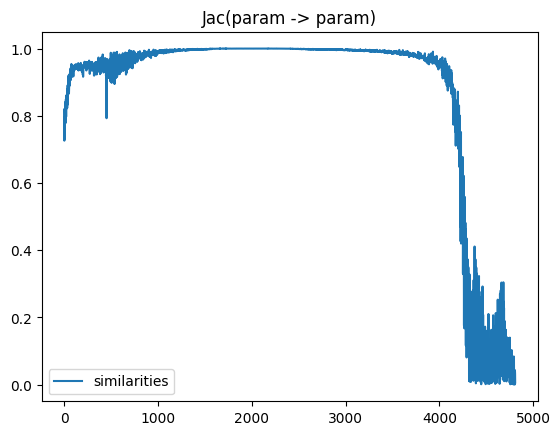

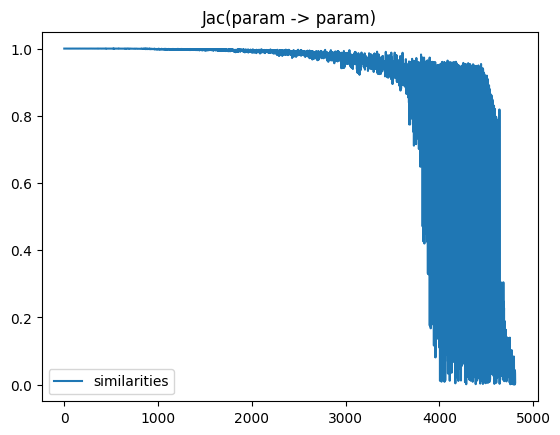

In [23]:
plt.plot(s_train, label="singular values")
plt.legend()
plt.yscale("log")
plt.title("Jac(param -> param)")
plt.show()

plt.plot(jnp.abs(jnp.diag(vh_train @ u_train)), label="similarities")
plt.legend()
plt.title("Jac(param -> param)")
plt.show()

plt.plot(jnp.abs(jnp.diag(vh_train @ u_train))[bulkfirst], label="similarities")
plt.legend()
plt.title("Jac(param -> param)")
plt.show()

In [24]:
dists_init = []
dists_final = []
dists_init_p = []
dists_final_p = []
dists_random = []

bulkdims = [1, 500, 3000]#jnp.arange(0, 3001, 500)

for bulkdim in tqdm(bulkdims):
    dists_init.append(geodesic_dist(vh_train[bulkfirst][:bulkdim], 
                               vh_init[-bulkdim:]))
    dists_final.append(geodesic_dist(vh_train[bulkfirst][:bulkdim], 
                               vh_final[-bulkdim:]))
    dists_init_p.append(geodesic_dist(vh_train[bulkfirst][:bulkdim], 
                               vh_init_p[-bulkdim:]))
    dists_final_p.append(geodesic_dist(vh_train[bulkfirst][:bulkdim], 
                               vh_final_p[-bulkdim:]))
    dists_random.append(geodesic_dist(vh_train[bulkfirst][:bulkdim], 
                               random_baseline[-bulkdim:]))


100%|██████████| 4/4 [00:47<00:00, 11.76s/it]


In [75]:
sims_init_lp = []
sims_init_random = []
# sims_final = []
# sims_init_p = []
# sims_final_p = []
sims_random = []

bulkdims = jnp.linspace(100, 3000, 10).astype(int)

for bulkdim in tqdm(bulkdims):
    sims_init_lp.append(principal_cosines(vh_train[bulkfirst][:bulkdim], 
                               vh_init_lp[-bulkdim:]).mean())
    sims_init_random.append(principal_cosines(vh_train[bulkfirst][:bulkdim], 
                               vh_random[-bulkdim:]).mean())
    # sims_final.append(principal_cosines(vh_train[bulkfirst][:bulkdim], 
    #                            vh_final[-bulkdim:]).mean())
    # sims_init_p.append(principal_cosines(vh_train[bulkfirst][:bulkdim], 
    #                            vh_init_p[-bulkdim:]).mean())
    # sims_final_p.append(principal_cosines(vh_train[bulkfirst][:bulkdim], 
    #                            vh_final_p[-bulkdim:]).mean())
    sims_random.append(principal_cosines(vh_train[bulkfirst][:bulkdim], 
                               random_baseline[-bulkdim:]).mean())


100%|██████████| 10/10 [01:04<00:00,  6.44s/it]


In [79]:

sims_init_random_lp = []

bulkdims = jnp.linspace(100, 3000, 10).astype(int)

for bulkdim in tqdm(bulkdims):
    sims_init_random_lp.append(principal_cosines(vh_train[bulkfirst][:bulkdim], 
                               vh_random_lp[-bulkdim:]).mean())

100%|██████████| 10/10 [00:21<00:00,  2.17s/it]


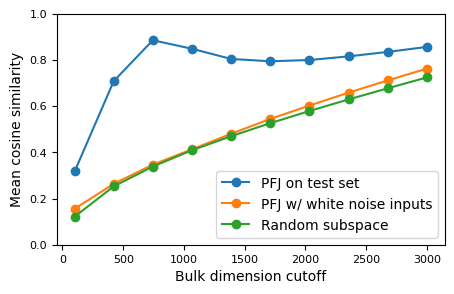

In [87]:
# aspect ratio
plot_setup(figsize=(5, 3))
plt.plot(bulkdims, sims_init_lp, '-o', label="PFJ on test set")
plt.plot(bulkdims, sims_init_random_lp, '-o', label="PFJ w/ white noise inputs")
plt.plot(bulkdims, sims_random, '-o', label="Random subspace")
plt.ylim(0, 1)
plt.legend()
plt.xlabel("Bulk dimension cutoff")
plt.ylabel("Mean cosine similarity")
#plt.title("Training vs function-space bulks")
# save as PDF
plt.savefig("PFJ_cosine_sims.pdf",bbox_inches='tight')
plt.show()

In [57]:
sims2_init = []
sims2_final = []
sims2_init_p = []
sims2_final_p = []
sims2_random = []

bulkdims = [1, 1000, 2000, 3000]#jnp.arange(0, 3001, 500)

for bulkdim in tqdm(bulkdims):
    sims2_init.append(jnp.linalg.trace(vh_train[bulkfirst][:bulkdim] @ vh_init[-bulkdim:].T) / bulkdim)
    sims2_final.append(jnp.linalg.trace(vh_train[bulkfirst][:bulkdim] @ vh_final[-bulkdim:].T) / bulkdim)
    sims2_init_p.append(jnp.linalg.trace(vh_train[bulkfirst][:bulkdim] @ vh_init_p[-bulkdim:].T) / bulkdim)
    sims2_final_p.append(jnp.linalg.trace(vh_train[bulkfirst][:bulkdim] @ vh_final_p[-bulkdim:].T) / bulkdim)
    sims2_random.append(jnp.linalg.trace(vh_train[bulkfirst][:bulkdim] @ random_baseline[-bulkdim:].T) / bulkdim) 

100%|██████████| 4/4 [00:00<00:00, 125.81it/s]


In [30]:
undists_init = []
undists_final = []
undists_init_p = []
undists_final_p = []
undists_random = []

bulkdims = [1000, 2000, 3000]#jnp.arange(0, 3001, 500)

for bulkdim in tqdm(bulkdims):
    undists_init.append(geodesic_dist(vh_train[bulkfirst][bulkdim:], 
                               vh_init[:-bulkdim]))
    undists_final.append(geodesic_dist(vh_train[bulkfirst][bulkdim:], 
                               vh_final[:-bulkdim]))
    undists_init_p.append(geodesic_dist(vh_train[bulkfirst][bulkdim:], 
                               vh_init_p[:-bulkdim]))
    undists_final_p.append(geodesic_dist(vh_train[bulkfirst][bulkdim:], 
                               vh_final_p[:-bulkdim]))
    undists_random.append(geodesic_dist(vh_train[bulkfirst][bulkdim:], 
                               random_baseline[:-bulkdim]))


100%|██████████| 3/3 [01:35<00:00, 31.99s/it]


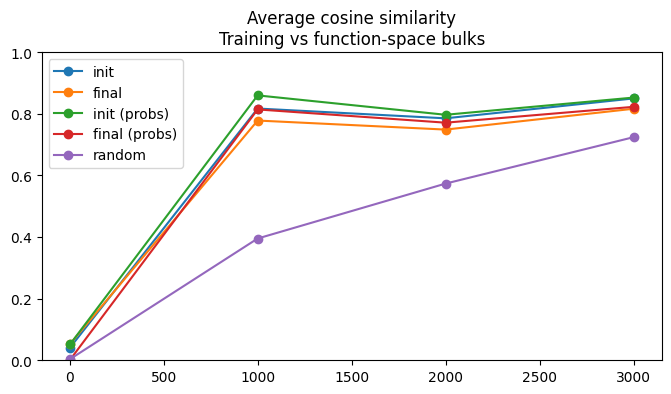

In [53]:
bulkdims = [1, 1000, 2000, 3000]
# aspect ratio
plt.figure(figsize=(8, 4))
plt.plot(bulkdims, sims_init, '-o', label="init")
plt.plot(bulkdims, sims_final, '-o', label="final")
plt.plot(bulkdims, sims_init_p, '-o', label="init (probs)")
plt.plot(bulkdims, sims_final_p, '-o', label="final (probs)")
plt.plot(bulkdims, sims_random, '-o', label="random")
plt.ylim(0, 1)
plt.legend()
plt.title("Average cosine similarity\nTraining vs function-space bulks")
plt.show()

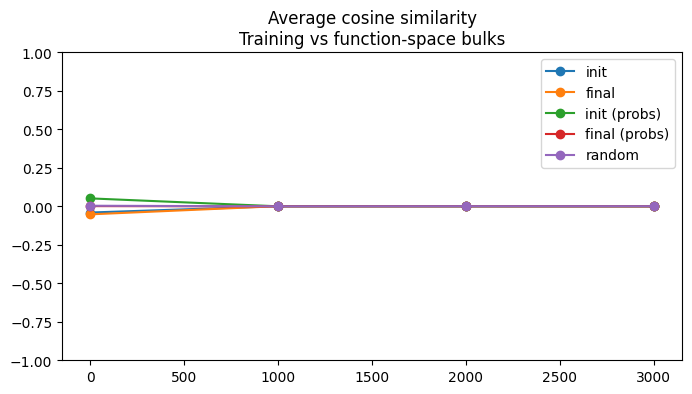

In [59]:
bulkdims = [1, 1000, 2000, 3000]
# aspect ratio
plt.figure(figsize=(8, 4))
plt.plot(bulkdims, sims2_init, '-o', label="init")
plt.plot(bulkdims, sims2_final, '-o', label="final")
plt.plot(bulkdims, sims2_init_p, '-o', label="init (probs)")
plt.plot(bulkdims, sims2_final_p, '-o', label="final (probs)")
plt.plot(bulkdims, sims2_random, '-o', label="random")
plt.ylim(-1, 1)
plt.legend()
plt.title("Average cosine similarity\nTraining vs function-space bulks")
plt.show()

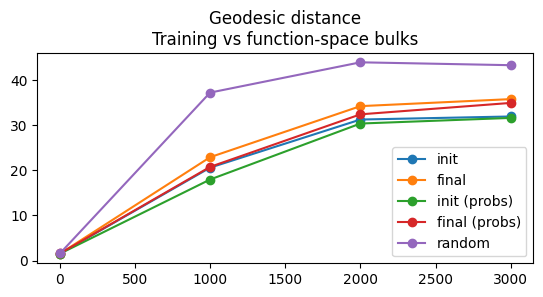

In [25]:
# aspect ratio of 2
plt.gca().set_aspect(30)
plt.plot(bulkdims, dists_init, '-o', label="init")
plt.plot(bulkdims, dists_final, '-o', label="final")
plt.plot(bulkdims, dists_init_p, '-o', label="init (probs)")
plt.plot(bulkdims, dists_final_p, '-o', label="final (probs)")
plt.plot(bulkdims, dists_random, '-o', label="random")
plt.legend()
plt.title("Geodesic distance\nTraining vs function-space bulks")
plt.show()

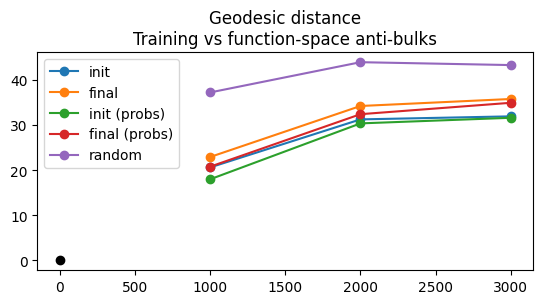

In [31]:
# aspect ratio of 2
plt.gca().set_aspect(30)
plt.plot(0, 0, '-o', color="black")
plt.plot(bulkdims, undists_init, '-o', label="init")
plt.plot(bulkdims, undists_final, '-o', label="final")
plt.plot(bulkdims, undists_init_p, '-o', label="init (probs)")
plt.plot(bulkdims, undists_final_p, '-o', label="final (probs)")
plt.plot(bulkdims, undists_random, '-o', label="random")
plt.legend()
plt.title("Geodesic distance\nTraining vs function-space anti-bulks")
plt.show()

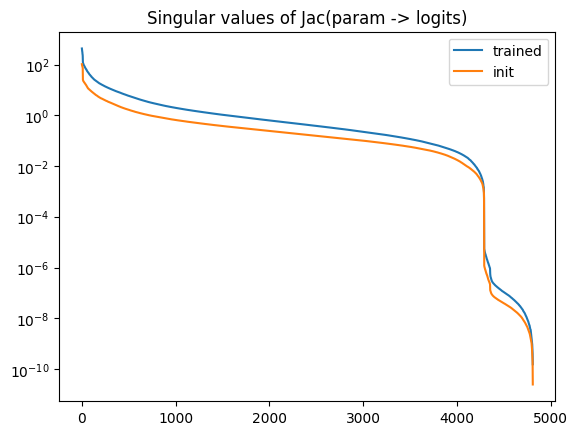

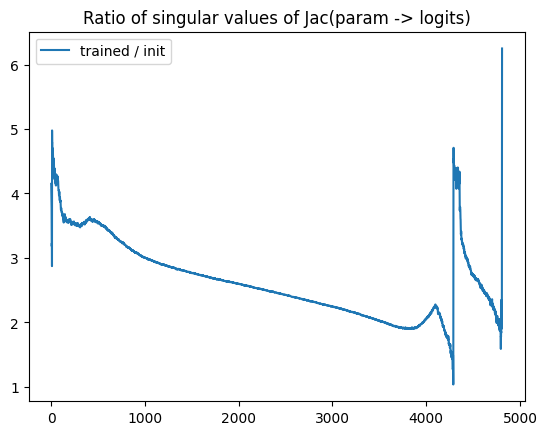

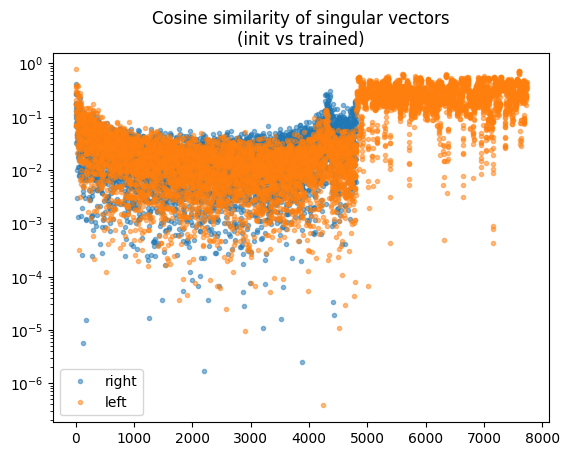

In [26]:
plt.plot(s_final, label="trained")
plt.plot(s_init, label="init")
plt.legend()
plt.yscale("log")
plt.title("Singular values of Jac(param -> logits)")
plt.show()

plt.plot(s_final / s_init, label="trained / init")
plt.legend()
#plt.yscale("log")
plt.title("Ratio of singular values of Jac(param -> logits)")
plt.show()

plt.plot(jnp.abs(jnp.diag(vh_final @ vh_init.T)), '.', alpha=0.5, label="right")
plt.plot(jnp.abs(jnp.diag(u_final.T @ u_init)), '.', alpha=0.5, label="left")
#plt.plot(jnp.abs(jnp.diag(vh @ random_baseline)), '.', alpha=0.5, label="random")
plt.legend()
plt.yscale("log")
plt.title("Cosine similarity of singular vectors\n(init vs trained)")
plt.show()


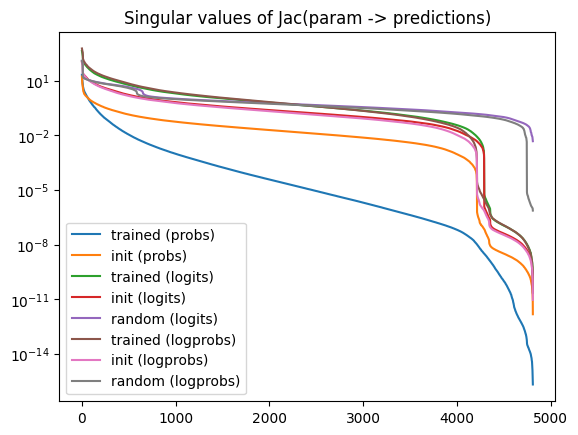

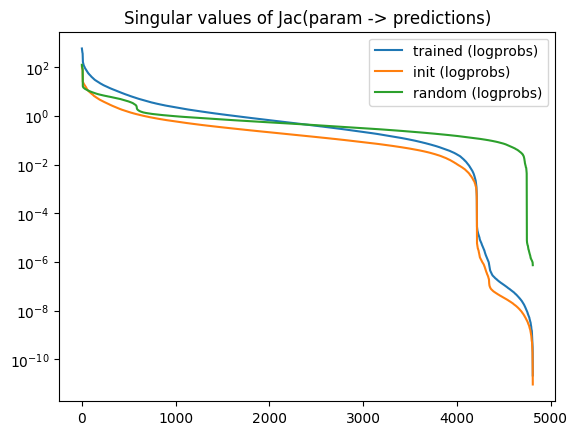

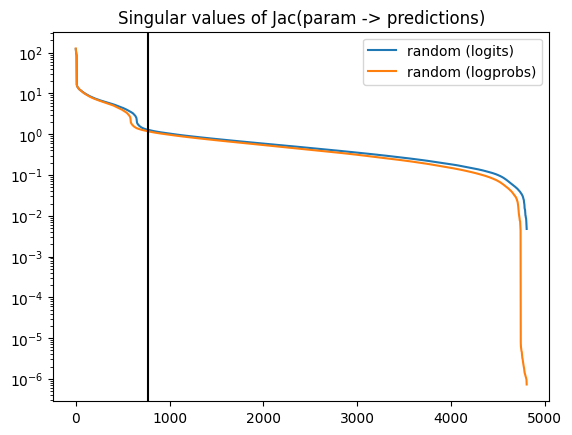

In [72]:
plt.plot(s_final_p, label="trained (probs)")
plt.plot(s_init_p, label="init (probs)")
plt.plot(s_final, label="trained (logits)")
plt.plot(s_init, label="init (logits)")
plt.plot(s_random, label="random (logits)")
plt.plot(s_final_lp, label="trained (logprobs)")
plt.plot(s_init_lp, label="init (logprobs)")
plt.plot(s_random_lp, label="random (logprobs)")
plt.legend()
plt.yscale("log")
plt.title("Singular values of Jac(param -> predictions)")
plt.show()

plt.plot(s_final_lp, label="trained (logprobs)")
plt.plot(s_init_lp, label="init (logprobs)")
plt.plot(s_random_lp, label="random (logprobs)")
plt.legend()
plt.yscale("log")
plt.title("Singular values of Jac(param -> predictions)")
plt.show()


plt.plot(s_random, label="random (logits)")
plt.plot(s_random_lp, label="random (logprobs)")
plt.axvline(X_random.shape[0], color="black")
plt.legend()
plt.yscale("log")
plt.title("Singular values of Jac(param -> predictions)")
plt.show()


In [104]:
s_random_lp[-66:]

Array([4.3550259e-03, 8.3848881e-06, 7.6543774e-06, 6.1864835e-06,
       6.1248957e-06, 5.8386977e-06, 5.6968979e-06, 5.4174679e-06,
       5.2389050e-06, 5.0700355e-06, 4.8199045e-06, 4.7214694e-06,
       4.6658802e-06, 4.5853503e-06, 4.1733388e-06, 3.8388443e-06,
       3.7397135e-06, 3.6475099e-06, 3.3653564e-06, 3.2197811e-06,
       3.1864345e-06, 3.1410293e-06, 3.0527181e-06, 2.9262515e-06,
       2.8400250e-06, 2.6182199e-06, 2.6101675e-06, 2.5078614e-06,
       2.3985194e-06, 2.3191956e-06, 2.2013778e-06, 2.1648582e-06,
       2.1303586e-06, 2.0722764e-06, 1.9902373e-06, 1.9196266e-06,
       1.8759154e-06, 1.8437846e-06, 1.7768176e-06, 1.6807895e-06,
       1.6072123e-06, 1.5882608e-06, 1.4667847e-06, 1.4605308e-06,
       1.3749394e-06, 1.3610161e-06, 1.3482559e-06, 1.3184232e-06,
       1.2822314e-06, 1.2705918e-06, 1.2419765e-06, 1.2194799e-06,
       1.2025689e-06, 1.1876728e-06, 1.1560065e-06, 1.1381654e-06,
       1.1192947e-06, 1.0873490e-06, 1.0734084e-06, 1.0451980e

In [106]:
X_train.shape, X_test.shape, X_random.shape

((1024, 64), (773, 64), (773, 64))

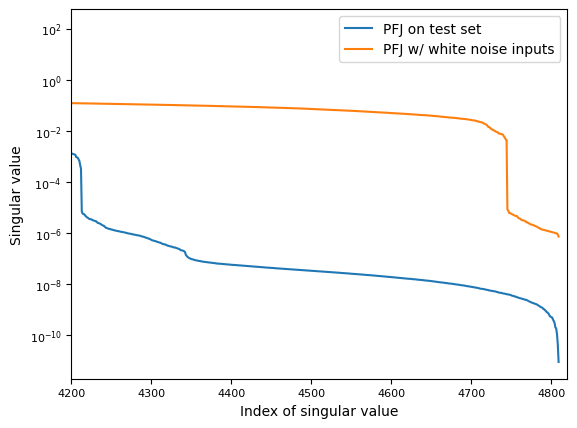

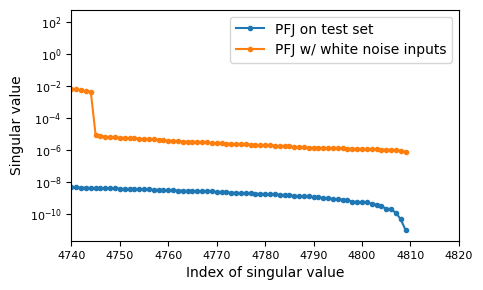

In [99]:


plt.plot(s_init_lp, label="PFJ on test set")
plt.plot(s_random_lp, label="PFJ w/ white noise inputs")
plt.xlim(4200, 4820)
plt.legend()
plt.yscale("log")
plt.xlabel("Index of singular value")
plt.ylabel("Singular value")
#plt.savefig("PFJ_singular_values.pdf",bbox_inches='tight')
plt.show()
plot_setup()
plt.plot(s_init_lp, '.-', label="PFJ on test set")
plt.plot(s_random_lp, '.-', label="PFJ w/ white noise inputs")
plt.xlim(4810-70, 4820)
plt.legend()
plt.yscale("log")
plt.xlabel("Index of singular value")
plt.ylabel("Singular value")
#plt.savefig("PFJ_singular_values.pdf",bbox_inches='tight')
plt.show()

In [78]:
dists = []

bulkdims = [0, 1500, 3000]#jnp.arange(0, 3001, 500)

for bulkdim in tqdm(bulkdims):
    dists.append(geodesic_dist(vh[-bulkdim:], random_baseline[-bulkdim:]))


100%|██████████| 3/3 [00:29<00:00,  9.76s/it]


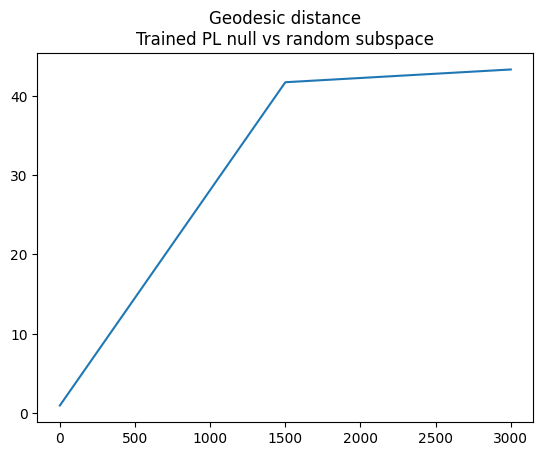

In [81]:
plt.plot(bulkdims, dists)
#plt.yscale("log")
plt.title("Geodesic distance\nTrained PL null vs random subspace")
plt.show()

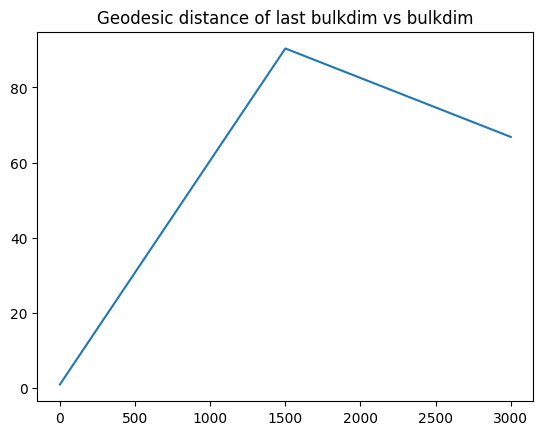

In [76]:
plt.plot(bulkdims, dists)
#plt.yscale("log")
plt.title("Geodesic distance of last bulkdim vs bulkdim")
plt.show()